|평가문항	|상세기준|
|:-|:-|
|1. CSR matrix가 정상적으로 만들어졌다.	|사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.|
|2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.	|사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.|
|3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.	|MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.|

# 3-1. 프로젝트 - Movielens 영화 추천 실습
이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.  

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.  

유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.  
별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.  
별점을 시청횟수로 해석해서 생각하겠습니다.  
또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.  
Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.  

Cloud shell에서 아래 명령어를 입력해 주세요.  
```
$ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
$ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m
```
프로젝트에 필요한 주요 라이브러리 버전을 확인해봅시다.

In [1]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


## 1) 데이터 준비와 전처리
Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [2]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [6]:
ratings[ratings.duplicated()]

,user_id,movie_id,counts,timestamp


In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


여기까지가 전처리입니다. 이후에는 이전 스텝에 소개했던 것과 동일한 방식으로 MF model을 구성하여 내가 좋아할 만한 영화를 추천해 볼 수 있습니다.

In [8]:
# 검색을 쉽게 하기 위해 제목 문자열을 소문자로 바꾸기
movies['title'] = movies['title'].str.lower()
movies.head()

,movie_id,title,genre
0,1,toy story (1995),Animation|Children's|Comedy
1,2,jumanji (1995),Adventure|Children's|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama
4,5,father of the bride part ii (1995),Comedy


In [9]:
movies[movies.duplicated()]

,movie_id,title,genre


In [10]:
user_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/users.dat'
cols = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv(user_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
users.head()

,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
users[users.duplicated()]

,user_id,gender,age,occupation,zip-code


In [12]:
# movies와 ratings를 movie_id로 join
movies_ratings = pd.merge(movies, ratings, on='movie_id')
movies_ratings

,movie_id,title,genre,user_id,counts,timestamp
0,1,toy story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,toy story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,toy story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,toy story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,toy story (1995),Animation|Children's|Comedy,10,5,978226474
...,...,...,...,...,...,...
836473,3952,"contender, the (2000)",Drama|Thriller,5682,3,1029457829
836474,3952,"contender, the (2000)",Drama|Thriller,5812,4,992072099
836475,3952,"contender, the (2000)",Drama|Thriller,5831,3,986223125
836476,3952,"contender, the (2000)",Drama|Thriller,5837,4,1011902656


In [13]:
# movies_ratings와 users를 user_id로 join
data = pd.merge(movies_ratings, users, on='user_id')
data

,movie_id,title,genre,user_id,counts,timestamp,gender,age,occupation,zip-code
0,1,toy story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,schindler's list (1993),Drama|War,1,5,978824195,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
836473,3785,scary movie (2000),Comedy|Horror,3043,3,970248335,M,18,2,90069
836474,3786,but i'm a cheerleader (1999),Comedy,3043,3,970248336,M,18,2,90069
836475,3852,"tao of steve, the (2000)",Comedy,3043,5,970248316,M,18,2,90069
836476,3882,bring it on (2000),Comedy,3043,5,970248316,M,18,2,90069


In [14]:
# 중복값 확인
data[data.duplicated(keep=False)]

,movie_id,title,genre,user_id,counts,timestamp,gender,age,occupation,zip-code


중복값 없음.

In [15]:
data['genre'].unique()

array(["Animation|Children's|Comedy",
       "Animation|Children's|Musical|Romance", 'Drama',
       'Action|Adventure|Fantasy|Sci-Fi', 'Drama|War', "Children's|Drama",
       "Animation|Children's|Comedy|Musical",
       "Animation|Children's|Musical", 'Crime|Drama|Thriller',
       'Animation', 'Animation|Comedy|Thriller', 'Musical|Romance',
       "Adventure|Children's|Drama|Musical", 'Musical',
       "Children's|Comedy|Musical", "Children's|Drama|Fantasy|Sci-Fi",
       'Action|Adventure|Comedy|Romance', 'Comedy|Sci-Fi',
       'Action|Adventure|Drama',
       "Adventure|Animation|Children's|Comedy|Musical", 'Drama|Romance',
       "Animation|Children's", 'Action|Drama|War', 'Comedy', 'Romance',
       'Action|Crime|Romance', 'Thriller', 'Comedy|Fantasy',
       'Comedy|Drama', "Children's|Comedy|Drama", 'Drama|Musical',
       'Drama|Romance|War|Western', 'Action|Comedy|Western',
       'Action|Romance|Thriller', 'Western', "Children's|Comedy",
       'Adventure|Drama|Western', '

최대 4개의 장르를 포함하고 있는 것 같다.

In [16]:
# 'genre' 컬럼을 '|'를 기준으로 분리하고, expand=True로 각각의 분리된 값이 별도의 컬럼으로 오도록 설정
genres_split = data['genre'].str.split('|', expand=True)

# 결과 데이터프레임에 최대 4개의 장르 컬럼을 추가
data['genre_1'] = genres_split[0]
data['genre_2'] = genres_split[1]
data['genre_3'] = genres_split[2]
data['genre_4'] = genres_split[3]

# 기존 genre 컬럼 삭제
data.drop('genre', axis=1, inplace=True)

# 새로운 컬럼을 포함한 상위 몇 행을 확인
data

,movie_id,title,user_id,counts,timestamp,gender,age,occupation,zip-code,genre_1,genre_2,genre_3,genre_4
0,1,toy story (1995),1,5,978824268,F,1,10,48067,Animation,Children's,Comedy,None
1,48,pocahontas (1995),1,5,978824351,F,1,10,48067,Animation,Children's,Musical,Romance
2,150,apollo 13 (1995),1,5,978301777,F,1,10,48067,Drama,None,None,None
3,260,star wars: episode iv - a new hope (1977),1,4,978300760,F,1,10,48067,Action,Adventure,Fantasy,Sci-Fi
4,527,schindler's list (1993),1,5,978824195,F,1,10,48067,Drama,War,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
836473,3785,scary movie (2000),3043,3,970248335,M,18,2,90069,Comedy,Horror,None,None
836474,3786,but i'm a cheerleader (1999),3043,3,970248336,M,18,2,90069,Comedy,None,None,None
836475,3852,"tao of steve, the (2000)",3043,5,970248316,M,18,2,90069,Comedy,None,None,None
836476,3882,bring it on (2000),3043,5,970248316,M,18,2,90069,Comedy,None,None,None


In [17]:
# 필요한 컬럼만 사용
data.drop(['timestamp', 'zip-code'], axis=1, inplace=True)
data

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4
0,1,toy story (1995),1,5,F,1,10,Animation,Children's,Comedy,None
1,48,pocahontas (1995),1,5,F,1,10,Animation,Children's,Musical,Romance
2,150,apollo 13 (1995),1,5,F,1,10,Drama,None,None,None
3,260,star wars: episode iv - a new hope (1977),1,4,F,1,10,Action,Adventure,Fantasy,Sci-Fi
4,527,schindler's list (1993),1,5,F,1,10,Drama,War,None,None
...,...,...,...,...,...,...,...,...,...,...,...
836473,3785,scary movie (2000),3043,3,M,18,2,Comedy,Horror,None,None
836474,3786,but i'm a cheerleader (1999),3043,3,M,18,2,Comedy,None,None,None
836475,3852,"tao of steve, the (2000)",3043,5,M,18,2,Comedy,None,None,None
836476,3882,bring it on (2000),3043,5,M,18,2,Comedy,None,None,None


In [18]:
# 영화 제목에서 연도도 분리
import pandas as pd

# 연도 추출
data['year'] = data['title'].str.extract('\((\d{4})\)')

# # 연도 컬럼에서 괄호 제거
# data['year'] = data['year'].str.extract('(\d{4})')

# 제목에서 연도 정보 제거
data['title'] = data['title'].str.replace('\(\d{4}\)', '', regex=True)

# 제목 끝의 공백 제거
data['title'] = data['title'].str.strip()

# 변경된 데이터프레임 상위 몇 행 확인
data

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
0,1,toy story,1,5,F,1,10,Animation,Children's,Comedy,None,1995
1,48,pocahontas,1,5,F,1,10,Animation,Children's,Musical,Romance,1995
2,150,apollo 13,1,5,F,1,10,Drama,None,None,None,1995
3,260,star wars: episode iv - a new hope,1,4,F,1,10,Action,Adventure,Fantasy,Sci-Fi,1977
4,527,schindler's list,1,5,F,1,10,Drama,War,None,None,1993
...,...,...,...,...,...,...,...,...,...,...,...,...
836473,3785,scary movie,3043,3,M,18,2,Comedy,Horror,None,None,2000
836474,3786,but i'm a cheerleader,3043,3,M,18,2,Comedy,None,None,None,1999
836475,3852,"tao of steve, the",3043,5,M,18,2,Comedy,None,None,None,2000
836476,3882,bring it on,3043,5,M,18,2,Comedy,None,None,None,2000


첫 번째 유저가 어떤 영화를 봤는지 확인

In [19]:
data[data['user_id'] == 1][['title', 'year', 'genre_1', 'genre_2', 'genre_3', 'genre_4']]

,title,year,genre_1,genre_2,genre_3,genre_4
0,toy story,1995,Animation,Children's,Comedy,None
1,pocahontas,1995,Animation,Children's,Musical,Romance
2,apollo 13,1995,Drama,None,None,None
3,star wars: episode iv - a new hope,1977,Action,Adventure,Fantasy,Sci-Fi
4,schindler's list,1993,Drama,War,None,None
5,"secret garden, the",1993,Children's,Drama,None,None
6,aladdin,1992,Animation,Children's,Comedy,Musical
7,snow white and the seven dwarfs,1937,Animation,Children's,Musical,None
8,beauty and the beast,1991,Animation,Children's,Musical,None
9,fargo,1996,Crime,Drama,Thriller,None


In [20]:
# 첫 번째 사용자의 데이터 필터링
user_1_data = data[data['user_id'] == 1][['title', 'year', 'genre_1', 'genre_2', 'genre_3', 'genre_4']]

# 장르 컬럼들을 하나의 긴 열로 녹이기
melted_genres = user_1_data.melt(id_vars=['title', 'year'], value_vars=['genre_1', 'genre_2', 'genre_3', 'genre_4'], value_name='genre')
melted_genres

,title,year,variable,genre
0,toy story,1995,genre_1,Animation
1,pocahontas,1995,genre_1,Animation
2,apollo 13,1995,genre_1,Drama
3,star wars: episode iv - a new hope,1977,genre_1,Action
4,schindler's list,1993,genre_1,Drama
...,...,...,...,...
207,ferris bueller's day off,1986,genre_4,None
208,awakenings,1990,genre_4,None
209,toy story 2,1999,genre_4,None
210,"girl, interrupted",1999,genre_4,None


In [21]:
melted_genres[melted_genres['title'] == 'toy story']

,title,year,variable,genre
0,toy story,1995,genre_1,Animation
53,toy story,1995,genre_2,Children's
106,toy story,1995,genre_3,Comedy
159,toy story,1995,genre_4,None


In [22]:
# NaN 값 제거
melted_genres = melted_genres.dropna(subset=['genre'])

# 가장 많이 등장하는 장르 계산
favorite_genre = melted_genres['genre'].value_counts().idxmax()
melted_genres['genre'].value_counts()

Drama         21
Children's    20
Animation     18
Comedy        14
Musical       13
Romance        6
Action         5
Adventure      5
Thriller       3
Sci-Fi         3
Fantasy        3
Crime          2
War            2
Name: genre, dtype: int64

user 1은 drama, children's, animation 장르를 좋아한다.

## 2) 분석해 봅시다.
- 유니크한 영화 개수

In [23]:
data['movie_id'].nunique()

3628

- 유니크한 사용자 수

In [24]:
data['user_id'].nunique()

6039

- 가장 인기 있는 영화 30개(인기순)

In [25]:
movie_count = data.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
american beauty                                   3211
star wars: episode iv - a new hope                2910
star wars: episode v - the empire strikes back    2885
star wars: episode vi - return of the jedi        2716
saving private ryan                               2561
terminator 2: judgment day                        2509
silence of the lambs, the                         2498
raiders of the lost ark                           2473
back to the future                                2460
matrix, the                                       2434
jurassic park                                     2413
sixth sense, the                                  2385
fargo                                             2371
braveheart                                        2314
men in black                                      2297
schindler's list                                  2257
princess bride, the                               2252
shakespeare in love                               2213
l.a.

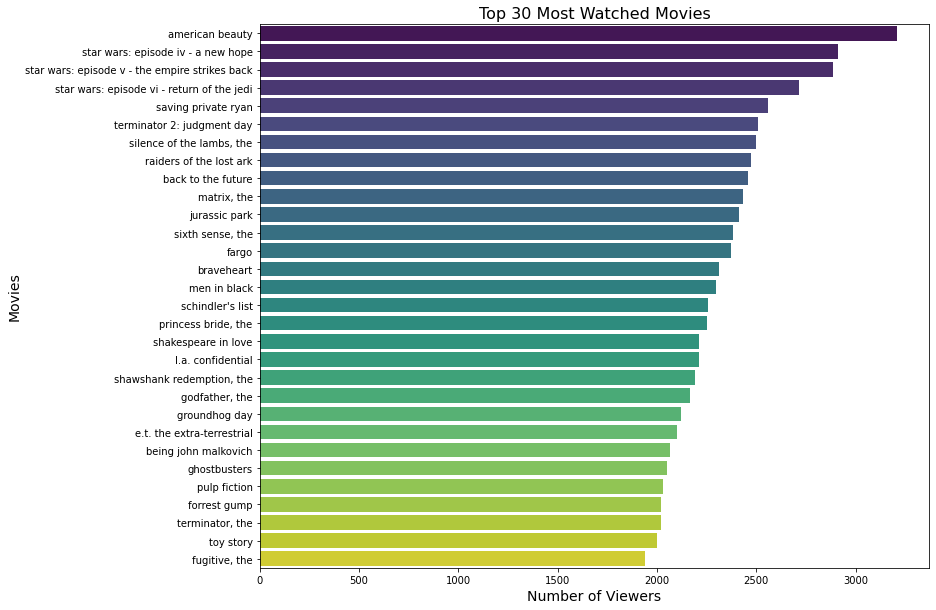

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

top_movies_30 = data.groupby('title')['user_id'].count().sort_values(ascending=False).head(30)

# 시각화 설정
plt.figure(figsize=(12, 10))
sns.barplot(x=top_movies_30.values, y=top_movies_30.index, palette='viridis')

# 차트 제목 및 라벨 설정
plt.title('Top 30 Most Watched Movies', fontsize=16)
plt.xlabel('Number of Viewers', fontsize=14)
plt.ylabel('Movies', fontsize=14)

# 시각화 표시
plt.show()

In [27]:
# 유저별 몇 편의 영화를 보고 있는지에 대한 통계
user_count = data.groupby('user_id')['title'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: title, dtype: float64

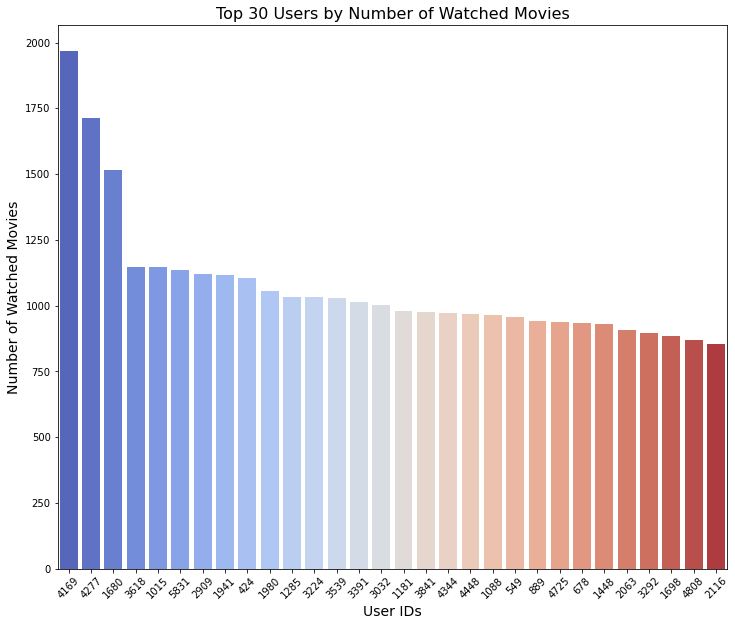

In [28]:
# 유저별 시청한 영화 수 계산 및 상위 30명 추출
user_count = data.groupby('user_id')['title'].count().sort_values(ascending=False).head(30)

# 유저 ID를 기준으로 내림차순 정렬
user_count_sorted = user_count.sort_values(ascending=False)

# 시각화 설정
plt.figure(figsize=(12, 10))
ax = sns.barplot(x=user_count_sorted.index, y=user_count_sorted.values, palette='coolwarm', order=user_count_sorted.index)

# 차트 제목 및 라벨 설정
plt.title('Top 30 Users by Number of Watched Movies', fontsize=16)
plt.ylabel('Number of Watched Movies', fontsize=14)
plt.xlabel('User IDs', fontsize=14)

# x축 눈금 라벨을 45도 회전하여 긴 텍스트 표시
plt.xticks(rotation=45)

# 시각화 표시
plt.show()


최상위 3명이 본 영화편수가 굉장히 압도적이다. 전체 유저가 본 영화 수의 중앙값이 81편에 달하는 것과 달리, 상위 30명은 모두 약 1000편의 영화를 보았다.

In [29]:
data['gender'].value_counts()

M    627933
F    208545
Name: gender, dtype: int64

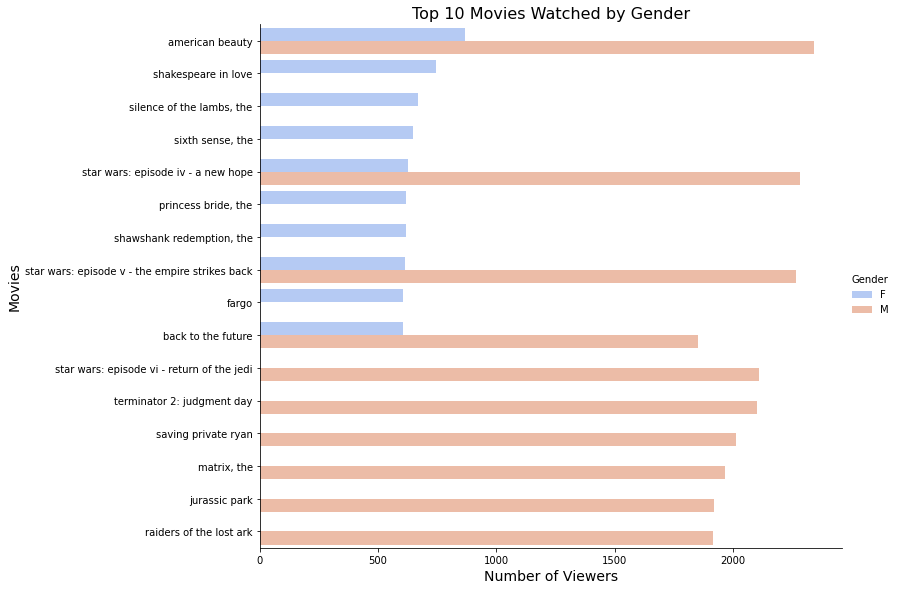

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# 성별별로 각 영화의 시청 횟수 계산
gender_movie_count = data.groupby(['gender', 'title']).size().reset_index(name='count')

# 성별별 상위 10개 영화 추출
top_movies_by_gender = gender_movie_count.groupby('gender').apply(lambda x: x.sort_values('count', ascending=False).head(10))

# 인덱스 재설정
top_movies_by_gender = top_movies_by_gender.reset_index(drop=True)

# 시각화 설정
g = sns.catplot(
    data=top_movies_by_gender,
    x='count', y='title', hue='gender', kind='bar',
    height=8, aspect=1.5, palette='coolwarm'
)

# 차트 제목 및 라벨 설정
plt.title('Top 10 Movies Watched by Gender', fontsize=16)
plt.xlabel('Number of Viewers', fontsize=14)
plt.ylabel('Movies', fontsize=14)

# 범례 제목 설정
g._legend.set_title('Gender')

# 시각화 표시
plt.show()

사람들이 좋아하는 상위권 영화는 대부분 남성들이 좋아하는 영화로 봐도 무방할 듯...

In [31]:
data['occupation'].nunique()

21

In [32]:
data['occupation'].value_counts()

0     107928
4     106610
7      89371
1      71541
17     62272
12     48961
20     48804
14     41604
2      41520
16     38990
6      31827
3      27019
15     19793
10     18662
5      18228
11     17170
13     12173
19     11652
18     10208
9       9907
8       2238
Name: occupation, dtype: int64

other or not specified(0), 대학생(4), 전문가(7), 교육자(1), 기술자(17)의 수가 가장 많았고, 프로그래머(12), 영업/마케팅 담당자(14), 작가(20), 예술가(2) 등이 뒤를 이었다.

## 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [34]:
my_favorite = ['chinatown', 'clueless', 'heathers', 'body heat', 'mary poppins']

In [35]:
# 영화 제목이 중복되지 않도록 drop_duplicates를 사용하여 첫 번째 값을 유지합니다.
movie_info_df = data.drop_duplicates(subset='title')[['movie_id', 'title', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'year']]

# 영화 제목을 key로 하고 다른 컬럼들을 value로 하는 사전 생성
movie_dict = movie_info_df.set_index('title').to_dict('index')

# 새로운 유저 데이터프레임을 생성합니다.
my_movies = pd.DataFrame({
    'user_id': [6040]*5,
    'title': my_favorite,  # 영화 제목 리스트
    'counts':[5]*5,
    'gender': ['F']*5,
    'age': [30.0]*5,
    'occupation': [0]*5
})

# my_movies에 영화 정보를 채워넣기 위한 과정
for i, row in my_movies.iterrows():
    title = row['title']
    movie_info = movie_dict.get(title)
    if movie_info:
        my_movies.at[i, 'movie_id'] = movie_info['movie_id']
        my_movies.at[i, 'genre_1'] = movie_info.get('genre_1')
        my_movies.at[i, 'genre_2'] = movie_info.get('genre_2')
        my_movies.at[i, 'genre_3'] = movie_info.get('genre_3')
        my_movies.at[i, 'genre_4'] = movie_info.get('genre_4')
        my_movies.at[i, 'year'] = movie_info.get('year')

# 마지막으로 my_movies 데이터프레임을 원본 data에 추가합니다.
data = pd.concat([data, my_movies], ignore_index=True)

# 결과 확인
data.tail(10)

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
836473,3785.0,scary movie,3043,3,M,18.0,2,Comedy,Horror,None,None,2000
836474,3786.0,but i'm a cheerleader,3043,3,M,18.0,2,Comedy,None,None,None,1999
836475,3852.0,"tao of steve, the",3043,5,M,18.0,2,Comedy,None,None,None,2000
836476,3882.0,bring it on,3043,5,M,18.0,2,Comedy,None,None,None,2000
836477,3897.0,almost famous,3043,5,M,18.0,2,Comedy,Drama,None,None,2000
836478,1252.0,chinatown,6040,5,F,30.0,0,Film-Noir,Mystery,Thriller,NaN,1974
836479,39.0,clueless,6040,5,F,30.0,0,Comedy,Romance,None,NaN,1995
836480,1285.0,heathers,6040,5,F,30.0,0,Comedy,None,None,NaN,1989
836481,2917.0,body heat,6040,5,F,30.0,0,Crime,Thriller,None,NaN,1981
836482,1028.0,mary poppins,6040,5,F,30.0,0,Children's,Comedy,Musical,NaN,1964


In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836483 entries, 0 to 836482
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   movie_id    836483 non-null  float64
 1   title       836483 non-null  object 
 2   user_id     836483 non-null  int64  
 3   counts      836483 non-null  int64  
 4   gender      836483 non-null  object 
 5   age         836483 non-null  float64
 6   occupation  836483 non-null  int64  
 7   genre_1     836483 non-null  object 
 8   genre_2     576697 non-null  object 
 9   genre_3     254938 non-null  object 
 10  genre_4     78184 non-null   object 
 11  year        836483 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 76.6+ MB


In [38]:
data = data.where(pd.notnull(data), None)
data.tail(10)

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
836473,3785.0,scary movie,3043,3,M,18.0,2,Comedy,Horror,None,None,2000
836474,3786.0,but i'm a cheerleader,3043,3,M,18.0,2,Comedy,None,None,None,1999
836475,3852.0,"tao of steve, the",3043,5,M,18.0,2,Comedy,None,None,None,2000
836476,3882.0,bring it on,3043,5,M,18.0,2,Comedy,None,None,None,2000
836477,3897.0,almost famous,3043,5,M,18.0,2,Comedy,Drama,None,None,2000
836478,1252.0,chinatown,6040,5,F,30.0,0,Film-Noir,Mystery,Thriller,None,1974
836479,39.0,clueless,6040,5,F,30.0,0,Comedy,Romance,None,None,1995
836480,1285.0,heathers,6040,5,F,30.0,0,Comedy,None,None,None,1989
836481,2917.0,body heat,6040,5,F,30.0,0,Crime,Thriller,None,None,1981
836482,1028.0,mary poppins,6040,5,F,30.0,0,Children's,Comedy,Musical,None,1964


In [39]:
data['movie_id'] = data['movie_id'].astype('Int64')
data['age'] = data['age'].astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836483 entries, 0 to 836482
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   movie_id    836483 non-null  Int64 
 1   title       836483 non-null  object
 2   user_id     836483 non-null  int64 
 3   counts      836483 non-null  int64 
 4   gender      836483 non-null  object
 5   age         836483 non-null  Int64 
 6   occupation  836483 non-null  int64 
 7   genre_1     836483 non-null  object
 8   genre_2     576697 non-null  object
 9   genre_3     254938 non-null  object
 10  genre_4     78184 non-null   object
 11  year        836483 non-null  object
dtypes: Int64(2), int64(3), object(7)
memory usage: 78.2+ MB


In [40]:
data

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
0,1,toy story,1,5,F,1,10,Animation,Children's,Comedy,None,1995
1,48,pocahontas,1,5,F,1,10,Animation,Children's,Musical,Romance,1995
2,150,apollo 13,1,5,F,1,10,Drama,None,None,None,1995
3,260,star wars: episode iv - a new hope,1,4,F,1,10,Action,Adventure,Fantasy,Sci-Fi,1977
4,527,schindler's list,1,5,F,1,10,Drama,War,None,None,1993
...,...,...,...,...,...,...,...,...,...,...,...,...
836478,1252,chinatown,6040,5,F,30,0,Film-Noir,Mystery,Thriller,None,1974
836479,39,clueless,6040,5,F,30,0,Comedy,Romance,None,None,1995
836480,1285,heathers,6040,5,F,30,0,Comedy,None,None,None,1989
836481,2917,body heat,6040,5,F,30,0,Crime,Thriller,None,None,1981


movie_id, user_id가 있으므로 굳이 인덱싱을 따로 해 줄 필요는 없다.

In [41]:
# 1회만 본 데이터의 비율을 보는 코드

# 각 user_id 별로 데이터 개수를 계산
user_counts = data['user_id'].value_counts()

# 데이터가 딱 한 번만 있는 user_id의 수를 계산
only_one_user = user_counts[user_counts == 1].count()

# 전체 user_id의 수
total_users = user_counts.count()

# 결과 출력
print(f'{only_one_user}, {total_users}')
print(f'Ratio of users who watched a movie only once over all users is {only_one_user / total_users:.2%}')

1, 6039
Ratio of users who watched a movie only once over all users is 0.02%


In [42]:
# 데이터가 딱 한 번만 있는 user_id를 필터링하여 리스트로 추출
only_one_user_ids = user_counts[user_counts == 1].index.tolist()

# 결과 출력
print(f'User IDs who watched a movie only once: {only_one_user_ids}')

User IDs who watched a movie only once: [4486]


In [43]:
data[data['user_id'] == 4486]

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
836427,2521,airport 1975,4486,3,M,35,8,Drama,None,None,None,1974


## 4) CSR matrix를 직접 만들어 봅시다.


user_id와 movie_id가 연속적이며 누락된 값 없이 0부터 시작하므로, max() + 1을 사용하여 CSR Matrix의 shape을 결정하는 것이 적절함

In [46]:
from scipy.sparse import csr_matrix

num_user = data['user_id'].max() + 1
num_movie = data['movie_id'].max() + 1

csr_data = csr_matrix((data['counts'], (data['user_id'], data['movie_id'])), shape=(num_user, num_movie))
csr_data

<6041x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836479 stored elements in Compressed Sparse Row format>

## 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [47]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [48]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [49]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6041 sparse matrix of type '<class 'numpy.int64'>'
	with 836479 stored elements in Compressed Sparse Column format>

In [50]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [52]:
user_id_6040 = 6040  # 예제 유저 ID
movie_id_chinatown = data[data['title'] == 'chinatown']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id

user_vector_6040 = als_model.user_factors[user_id_6040]
movie_vector_chinatown = als_model.item_factors[movie_id_chinatown]

preference_score = np.dot(user_vector_6040, movie_vector_chinatown)

In [53]:
user_vector_6040

array([-0.9480913 ,  1.7125002 , -0.29756156,  1.5686796 ,  0.36993745,
        2.8884673 ,  2.5466495 , -3.6393769 , -1.6707636 , -4.59904   ,
        0.99011433, -0.03699516, -2.1730142 , -1.5932374 ,  0.81319153,
       -1.0157918 ,  3.7842147 ,  3.617424  , -1.6429273 , -3.192341  ,
       -2.0339594 , -0.32381293, -1.5505183 , -4.2352624 , -3.3309968 ,
        3.0724986 ,  1.413247  , -2.515305  , -2.1080801 ,  0.50930625,
        1.225028  ,  0.9556759 ,  6.9942913 ,  2.0030928 ,  0.09134837,
        1.7714831 , -2.1753376 ,  0.6097773 ,  1.032749  ,  4.9610744 ,
        1.2807914 ,  0.07277372,  3.7446299 ,  1.931355  ,  5.588654  ,
        4.5861444 , -0.75440115,  3.9137793 ,  1.0247266 , -0.9505866 ,
        2.3854842 ,  0.9884045 ,  1.2439691 ,  0.98071104,  4.904685  ,
        0.12350963,  1.735596  , -0.30143166,  0.05047472, -0.81703657,
        2.2399523 ,  2.3023407 ,  0.5806914 , -2.4789743 ,  0.9356256 ,
       -1.0978912 , -4.3020763 , -0.28497615, -1.5023805 , -2.57

In [54]:
movie_vector_chinatown

array([-0.00064741,  0.02819488,  0.01904231, -0.02414444, -0.01607139,
       -0.00509419, -0.0356661 , -0.01081972, -0.00572399,  0.01458557,
       -0.00497512,  0.00730921,  0.00394963,  0.02017706,  0.00432492,
        0.01718513, -0.01323154,  0.03602398, -0.00827851,  0.00043817,
        0.0120036 , -0.0006824 , -0.01446244,  0.00101421, -0.01473587,
        0.03541576,  0.04156588, -0.00946741, -0.03550065,  0.01453293,
        0.01299226, -0.00856249,  0.01225256,  0.00561415, -0.00945769,
       -0.00499251,  0.01584661,  0.00087713, -0.01139596,  0.01854087,
        0.01036711,  0.03071502, -0.02797033, -0.00636568,  0.01212395,
        0.00783673, -0.00640477,  0.03180338,  0.00767115,  0.02812341,
        0.02902426,  0.01217375,  0.00330299, -0.02590831,  0.01082658,
        0.02454775, -0.00097271,  0.00856871, -0.00348171, -0.00034664,
        0.02089185,  0.00434348, -0.00630118, -0.02389019,  0.00367791,
        0.00159108, -0.01688515, -0.00766757, -0.00917397, -0.00

In [55]:
np.dot(user_vector_6040, movie_vector_chinatown)

1.0298809

In [56]:
data[data['title'] == 'chinatown']

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
494,1252,chinatown,10,3,F,35,1,Film-Noir,Mystery,Thriller,None,1974
1305,1252,chinatown,23,3,M,35,0,Film-Noir,Mystery,Thriller,None,1974
3277,1252,chinatown,49,5,M,18,12,Film-Noir,Mystery,Thriller,None,1974
4975,1252,chinatown,112,5,M,25,16,Film-Noir,Mystery,Thriller,None,1974
6046,1252,chinatown,123,5,M,35,9,Film-Noir,Mystery,Thriller,None,1974
...,...,...,...,...,...,...,...,...,...,...,...,...
833039,1252,chinatown,1977,5,M,56,6,Film-Noir,Mystery,Thriller,None,1974
834456,1252,chinatown,5125,5,M,45,0,Film-Noir,Mystery,Thriller,None,1974
834791,1252,chinatown,2373,4,M,45,7,Film-Noir,Mystery,Thriller,None,1974
835345,1252,chinatown,2422,3,F,50,9,Film-Noir,Mystery,Thriller,None,1974


차이나타운은 누아르, 미스터리, 스릴러 장르이다.

In [ ]:
my_favorite = ['chinatown', 'clueless', 'heathers', 'body heat', 'mary poppins']

In [61]:
data[data['title'] == 'clueless']

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
130,39,clueless,8,3,M,25,12,Comedy,Romance,None,None,1995
1223,39,clueless,23,4,M,35,0,Comedy,Romance,None,None,1995
1463,39,clueless,26,3,M,25,7,Comedy,Romance,None,None,1995
1737,39,clueless,28,4,F,25,1,Comedy,Romance,None,None,1995
1837,39,clueless,34,4,F,18,0,Comedy,Romance,None,None,1995
...,...,...,...,...,...,...,...,...,...,...,...,...
761573,39,clueless,5362,5,M,35,13,Comedy,Romance,None,None,1995
761636,39,clueless,5480,4,F,25,14,Comedy,Romance,None,None,1995
761761,39,clueless,5553,4,M,35,3,Comedy,Romance,None,None,1995
762005,39,clueless,5952,4,F,45,1,Comedy,Romance,None,None,1995


In [62]:
data[data['title'] == 'heathers']

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
1562,1285,heathers,26,3,M,25,7,Comedy,None,None,None,1989
1788,1285,heathers,28,5,F,25,1,Comedy,None,None,None,1989
1874,1285,heathers,34,5,F,18,0,Comedy,None,None,None,1989
2099,1285,heathers,36,3,M,25,3,Comedy,None,None,None,1989
6062,1285,heathers,123,4,M,35,9,Comedy,None,None,None,1989
...,...,...,...,...,...,...,...,...,...,...,...,...
832601,1285,heathers,527,5,F,25,2,Comedy,None,None,None,1989
833489,1285,heathers,766,3,F,25,7,Comedy,None,None,None,1989
833530,1285,heathers,3870,4,M,25,17,Comedy,None,None,None,1989
835446,1285,heathers,1770,4,M,35,16,Comedy,None,None,None,1989


In [63]:
data[data['title'] == 'body heat']

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
1409,2917,body heat,23,5,M,35,0,Crime,Thriller,None,None,1981
5664,2917,body heat,118,4,M,35,17,Crime,Thriller,None,None,1981
6292,2917,body heat,123,4,M,35,9,Crime,Thriller,None,None,1981
7370,2917,body heat,146,5,F,35,20,Crime,Thriller,None,None,1981
8596,2917,body heat,149,5,M,25,1,Crime,Thriller,None,None,1981
...,...,...,...,...,...,...,...,...,...,...,...,...
825674,2917,body heat,5238,3,F,50,16,Crime,Thriller,None,None,1981
828553,2917,body heat,2413,4,F,56,7,Crime,Thriller,None,None,1981
830647,2917,body heat,1346,5,M,35,20,Crime,Thriller,None,None,1981
831964,2917,body heat,4737,5,M,35,16,Crime,Thriller,None,None,1981


In [64]:
data[data['title'] == 'mary poppins']

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
18,1028,mary poppins,1,5,F,1,10,Children's,Comedy,Musical,None,1964
73,1028,mary poppins,6,4,F,50,9,Children's,Comedy,Musical,None,1964
451,1028,mary poppins,10,5,F,35,1,Children's,Comedy,Musical,None,1964
807,1028,mary poppins,18,5,F,18,3,Children's,Comedy,Musical,None,1964
1860,1028,mary poppins,34,5,F,18,0,Children's,Comedy,Musical,None,1964
...,...,...,...,...,...,...,...,...,...,...,...,...
832232,1028,mary poppins,5028,3,M,25,12,Children's,Comedy,Musical,None,1964
833279,1028,mary poppins,3463,3,M,25,15,Children's,Comedy,Musical,None,1964
834084,1028,mary poppins,2356,4,F,50,16,Children's,Comedy,Musical,None,1964
834901,1028,mary poppins,4442,5,M,50,15,Children's,Comedy,Musical,None,1964


my_favorite에 포함된 영화는 각각 누아르, 미스터리, 스릴러, 코미디, 로맨스, 범죄, 아동(가족), 뮤지컬 등 넓은 범위를 가지고 있다.

In [65]:
data.sample(10)

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
711114,3717,gone in 60 seconds,4210,4,M,25,17,Action,Crime,None,None,2000
730076,1204,lawrence of arabia,4649,5,M,56,13,Adventure,War,None,None,1962
194600,2019,seven samurai (the magnificent seven) (shichin...,2544,5,M,45,1,Action,Drama,None,None,1954
783997,246,hoop dreams,3642,4,F,25,7,Documentary,None,None,None,1994
478897,2528,logan's run,3140,4,F,25,4,Action,Adventure,Sci-Fi,None,1976
23416,3247,sister act,355,4,M,18,3,Comedy,Crime,None,None,1992
812584,2858,american beauty,2075,5,F,25,4,Comedy,Drama,None,None,1999
738088,2065,"purple rose of cairo, the",3621,3,M,18,4,Comedy,Drama,Romance,None,1985
500366,1357,shine,216,5,M,45,13,Drama,Romance,None,None,1996
226251,436,color of night,3051,3,M,18,17,Drama,Thriller,None,None,1994


겹치는 장르를 가지고 있지 않은 영화들에 대해 계산해보자.

In [66]:
# lawrence of arabia: 어드벤처, 전쟁

movie_id_arabia = data[data['title'] == 'lawrence of arabia']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_arabia = als_model.item_factors[movie_id_arabia]
np.dot(user_vector_6040, movie_vector_arabia)

0.54899603

In [67]:
# hoop dreams: 다큐멘터리

movie_id_hoop = data[data['title'] == 'hoop dreams']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_hoop = als_model.item_factors[movie_id_hoop]
np.dot(user_vector_6040, movie_vector_hoop)

0.9129094

In [74]:
# "Hoop Dreams" 영화를 여성이 평가한 경우만 필터링
filtered_data = data[(data['title'] == 'hoop dreams') & (data['gender'] == 'F')]
filtered_data.describe()

,movie_id,user_id,counts,age,occupation
count,158.0,158.000000,158.000000,158.000000,158.000000
mean,246.0,3095.227848,4.329114,32.246835,5.291139
std,0.0,1897.578819,0.690638,12.101843,5.823633
min,246.0,11.000000,3.000000,1.000000,0.000000
25%,246.0,1368.750000,4.000000,25.000000,1.000000
50%,246.0,2944.500000,4.000000,25.000000,3.000000
75%,246.0,4969.250000,5.000000,45.000000,7.000000
max,246.0,5976.000000,5.000000,56.000000,20.000000


In [75]:
# "Hoop Dreams" 영화를 남성이 평가한 경우만 필터링
filtered_data = data[(data['title'] == 'hoop dreams') & (data['gender'] == 'M')]
filtered_data.describe()

,movie_id,user_id,counts,age,occupation
count,534.0,534.000000,534.000000,534.000000,534.000000
mean,246.0,2921.280899,4.254682,29.039326,8.340824
std,0.0,1685.652847,0.723971,10.528098,6.766262
min,246.0,36.000000,3.000000,1.000000,0.000000
25%,246.0,1495.000000,4.000000,25.000000,2.000000
50%,246.0,2822.000000,4.000000,25.000000,7.000000
75%,246.0,4308.250000,5.000000,35.000000,15.000000
max,246.0,6040.000000,5.000000,56.000000,20.000000


좋아하는 영화의 장르가 겹치지 않음에도 비슷한 연령대의 사람들이 좋은 평점을 남겼기 때문에 내적값이 높은 것으로 추정된다.

In [77]:
# logan's run: 액션, 어드벤처, SF
movie_id_logan = data[data['title'] == "logan's run"]['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_logan = als_model.item_factors[movie_id_logan]
np.dot(user_vector_6040, movie_vector_logan)

0.23830856

이번엔 겹치는 장르에 대해 얼마나 선호할지를 알아보자.  
(my_favorite에 포함된 영화는 각각 누아르, 미스터리, 스릴러, 코미디, 로맨스, 범죄, 아동(가족), 뮤지컬)

In [79]:
# gone in 60 seconds: 액션, 범죄 (하나 겹침)
movie_id_60s = data[data['title'] == 'gone in 60 seconds']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_60s = als_model.item_factors[movie_id_60s]
np.dot(user_vector_6040, movie_vector_60s)

0.23483372

액션은 선호하지 않을 것으로 판단하고 있는 것 같다.

In [80]:
# sister act: 코미디, 범죄 (2개 겹침)
movie_id_sister = data[data['title'] == 'sister act']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_sister = als_model.item_factors[movie_id_sister]
np.dot(user_vector_6040, movie_vector_sister)

0.08738264

In [81]:
# "sister act" 영화를 여성이 평가한 경우만 필터링
filtered_data = data[(data['title'] == 'sister act') & (data['gender'] == 'F')]
filtered_data.describe()

,movie_id,user_id,counts,age,occupation
count,190.0,190.000000,190.000000,190.000000,190.000000
mean,3247.0,3094.252632,3.726316,29.289474,6.915789
std,0.0,1776.594152,0.673648,12.791589,6.334859
min,3247.0,10.000000,3.000000,1.000000,0.000000
25%,3247.0,1615.250000,3.000000,18.000000,1.000000
50%,3247.0,3211.000000,4.000000,25.000000,4.000000
75%,3247.0,4585.000000,4.000000,35.000000,12.000000
max,3247.0,6006.000000,5.000000,56.000000,20.000000


In [82]:
# "sister act" 영화를 남성이 평가한 경우만 필터링
filtered_data = data[(data['title'] == 'sister act') & (data['gender'] == 'M')]
filtered_data.describe()

,movie_id,user_id,counts,age,occupation
count,318.0,318.000000,318.000000,318.000000,318.000000
mean,3247.0,2940.638365,3.566038,28.770440,8.308176
std,0.0,1744.493832,0.674252,11.917731,6.463144
min,3247.0,31.000000,3.000000,1.000000,0.000000
25%,3247.0,1442.500000,3.000000,18.000000,3.250000
50%,3247.0,2952.500000,3.000000,25.000000,7.000000
75%,3247.0,4402.250000,4.000000,35.000000,15.000000
max,3247.0,6023.000000,5.000000,56.000000,20.000000


In [83]:
# "sister act" 영화를 여성이 평가한 경우만 필터링
filtered_data = data[(data['title'] == 'sister act') & (data['occupation'] == 0)]
filtered_data.describe()

,movie_id,user_id,counts,age,occupation
count,71.0,71.000000,71.000000,71.000000,71.0
mean,3247.0,2801.521127,3.676056,29.281690,0.0
std,0.0,1832.628969,0.732406,12.340622,0.0
min,3247.0,40.000000,3.000000,1.000000,0.0
25%,3247.0,1214.000000,3.000000,25.000000,0.0
50%,3247.0,2938.000000,4.000000,25.000000,0.0
75%,3247.0,4035.500000,4.000000,35.000000,0.0
max,3247.0,6023.000000,5.000000,56.000000,0.0


비슷한 성별, 연령, 직업군을 갖는 사람들 모두가 중간 이상의 평점을 주고 있음에도 추천 점수가 매우 낮다. 왜일까?

In [84]:
# american beauty: 코미디, 드라마 (1개 겹침 (코미디))
movie_id_american = data[data['title'] == 'american beauty']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_american = als_model.item_factors[movie_id_american]
np.dot(user_vector_6040, movie_vector_american)

0.9888786

이 경우는 장르가 하나만 겹침에도 추천 점수가 매우 높다.

In [93]:
# 각 영화가 'Comedy'와 'Crime' 장르를 모두 포함하는지 여부를 나타내는 새로운 컬럼을 생성
data['is_comedy_crime'] = data.apply(lambda x: 'Comedy' in [x['genre_1'], x['genre_2'], x['genre_3'], x['genre_4']] and
                                               'Crime' in [x['genre_1'], x['genre_2'], x['genre_3'], x['genre_4']], axis=1)

# 'Comedy'와 'Crime' 장르를 모두 포함하는 영화들의 수를 계산
comedy_crime_count = data['is_comedy_crime'].sum()

# 전체 영화 수
total_movies = data['title'].count()

# 비중 계산
ratio_comedy_crime = comedy_crime_count / total_movies

print(f"Total number of movies: {total_movies}")
print(f"Number of movies that are both Comedy and Crime: {comedy_crime_count}")
print(f"Ratio of movies that are both Comedy and Crime: {ratio_comedy_crime:.2%}")

Total number of movies: 836483
Number of movies that are both Comedy and Crime: 15026
Ratio of movies that are both Comedy and Crime: 1.80%


많은 영화 중 comedy와 crime 장르를 함께 포함하는 비중이 매우 낮으므로, 애초에 자주 사용되는 장르 조합이 아닌 듯 하다...
따라서 추천 점수도 낮은 것으로 추정됨.

## 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.


In [97]:
favorite_movie = 'chinatown'
# 'Chinatown' 영화의 movie_id 찾기
movie_id = data[data['title'] == favorite_movie]['movie_id'].iloc[0]

# 비슷한 영화 찾기
similar_movies = als_model.similar_items(movie_id, N=15)
similar_movies

[(1252, 1.0),
 (1267, 0.7594973),
 (922, 0.57423544),
 (1248, 0.5727999),
 (1617, 0.5681902),
 (3435, 0.5215276),
 (1284, 0.51294345),
 (904, 0.5127752),
 (1212, 0.4981136),
 (913, 0.49529612),
 (2186, 0.49081495),
 (541, 0.4880397),
 (164, 0.4805797),
 (903, 0.45932066),
 (3683, 0.45165056)]

In [99]:
# 유사한 영화의 id를 기반으로 영화 제목 가져오기
similar_movie_ids = [movie_id for movie_id, _ in similar_movies]
similar_movie_titles = data[data['movie_id'].isin(similar_movie_ids)]['title'].unique()

# 결과 출력
print("Similar movies to 'hinatown':")
for title in similar_movie_titles:
    print(title)

Similar movies to 'chinatown':
l.a. confidential
blade runner
rear window
maltese falcon, the
chinatown
vertigo
third man, the
manchurian candidate, the
double indemnity
big sleep, the
devil in a blue dress
sunset blvd. (a.k.a. sunset boulevard)
touch of evil
strangers on a train
blood simple


대부분 느와르, 스릴러, 미스터리 장르를 추천해주고 있다.

In [100]:
def get_similar_movies(movie_title: str, N=15):
    # 주어진 영화 제목에 해당하는 movie_id 찾기
    movie_id = data[data['title'] == movie_title]['movie_id'].iloc[0]
    
    # 해당 movie_id를 기반으로 유사한 영화 찾기
    similar_movies = als_model.similar_items(movie_id, N=N)
    
    # 유사한 영화의 movie_id를 기반으로 영화 제목 가져오기
    similar_movie_ids = [movie_id for movie_id, _ in similar_movies]
    similar_movie_titles = data[data['movie_id'].isin(similar_movie_ids)]['title'].unique()
    
    return similar_movie_titles

In [103]:
similar_movies_to_poppins = get_similar_movies('mary poppins')
print("Similar movies to 'mary poppins':")
for title in similar_movies_to_poppins:
    print(title)

Similar movies to 'mary poppins':
snow white and the seven dwarfs
my fair lady
cinderella
mary poppins
dumbo
sound of music, the
grease
west side story
little mermaid, the
alice in wonderland
jungle book, the
lady and the tramp
peter pan
sleeping beauty
oliver!
